In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
mpl.use('cairo')
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
graph = 'lattice-1024'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_method = "leaves"
dataset_id = '{}-mic-s0.02-o{}'.format(graph, obs_method)
cascade_dir = 'cascade/{}'.format(dataset_id)


In [4]:
cascade_id = 35

In [5]:
g = load_graph_by_name(graph, weighted=True)
g_rev = load_graph_by_name(graph, weighted=True, suffix="_reversed")
g_und = GraphView(g, directed=False)
g_und.set_directed(False)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-1024/graph_weighted.gt
load graph from data/lattice-1024/graph_weighted_reversed.gt


In [6]:
if False:
    obs, c, tree = gen_input(g, source=18, p=get_edge_weights(g), model='ic', observation_method='leaves', 
                             min_size=15, max_size=80, return_tree=True)
    pkl.dump((obs, c, tree), open('cascade-weighted/{}-example.pkl'.format(graph), 'wb'))    
else:
    obs, c, tree = pkl.load(open('cascade-weighted/{}-example.pkl'.format(graph), 'rb'))
inf_nodes = infected_nodes(c)
hidden_infs = set(inf_nodes) - set(obs)
source = cascade_source(c)

In [8]:
from helpers import cascade_info
cascade_info(obs, c)

source: 18
|casdade|: 15
|observed nodes|: 5


In [7]:
gv = remove_filters(g_rev)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=10000,
    method=sampling_method,
    gi=gi,
    return_type='nodes',
    with_resampling=False,
    with_inc_sampling=False)

params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.0,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}
q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

In [9]:
qs = sim.run(1, obs, c)
queries = qs[0]

  0%|          | 0/1 [00:00<?, ?it/s]

pruning candidates from 1019 to 1017
no estimation node sampling
num. queries reached


In [ ]:
pd.Series([len(t) for t in sampler.samples]).hist()

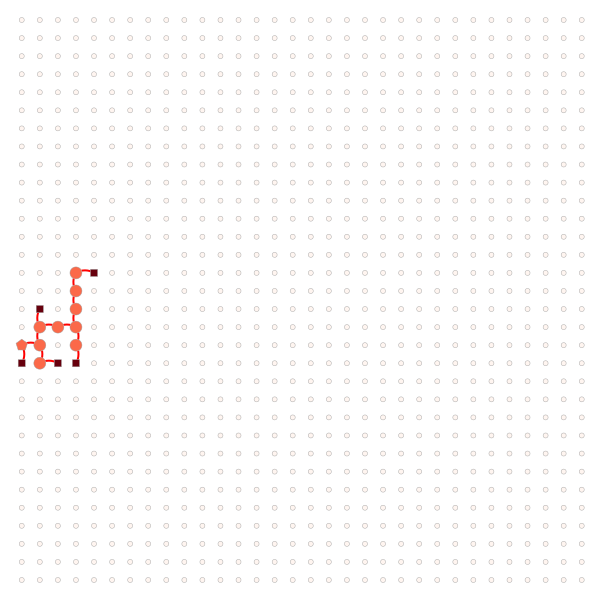

In [23]:
setting = tree_plot_setting(g_und, c, obs, tuple(extract_edges(tree)))
visualize(g_und, pos, **setting, output='figs/why-prederror-fails/cascade.png')

In [ ]:
q_gen.query_scores[queries[0]]

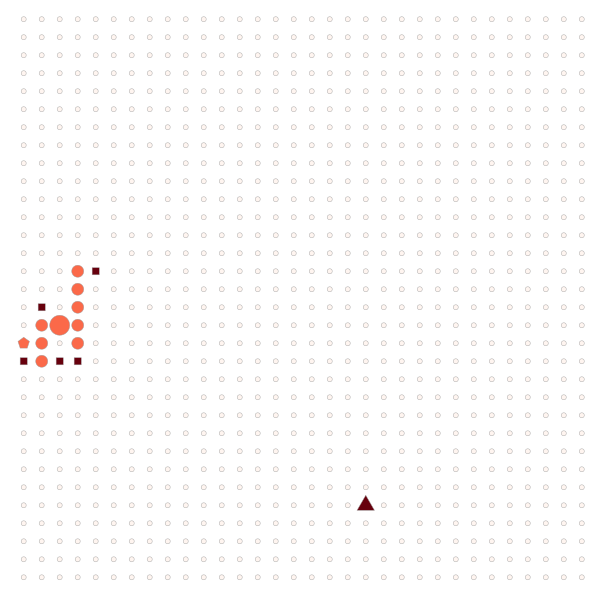

In [44]:
s = query_plot_setting(g, c, obs, queries)
col, row = 2, 17
better_query = n * col + row
s['node_size_info'][tuple([better_query])] = 20
# s['node_color_info'][tuple([i])] = 1.0
visualize(g_und, pos, **s, output='figs/why-prederror-fails/two-candidate-queries.png')

In [45]:
estimator = TreeBasedStatistics(g, sampler.samples)

probas = infection_probability(g, obs, sampler, estimator)

In [46]:
print('entropy before querying: {}'.format(
    estimator._sum_entropy(estimator._smooth_extreme_vals(probas))))

entropy before querying: 204.3207299935549


In [47]:
print('for the first query')
print('query score', q_gen.query_scores[queries[0]])
aux = q_gen.aux[queries[0]]
p0, p1 = aux['p0'], aux['p1']
aux

for the first query
query score 196.27229662668486


{'errors': array([183.79376204, 475.34830842]),
 'p0': array([0.00031341, 0.00229837, 0.00344756, ..., 0.00125366, 0.00083577,
        0.00083577]),
 'p1': array([0.00233645, 0.0046729 , 0.00934579, ..., 0.03738318, 0.03271028,
        0.02336449]),
 'weights': (0.9572, 0.0428)}

In [48]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.switch_backend('cairo')

# a tree that contains the best query
q1, q2 = queries[0], better_query
trees_q1 = [sample for sample in sampler.samples if q1 in sample]
trees_not_q1 = [sample for sample in sampler.samples if q1 not in sample]

trees_q2 = [sample for sample in sampler.samples if q2 in sample]
trees_not_q2 = [sample for sample in sampler.samples if q2 not in sample]

# s = query_plot_setting(g, c, obs, tree_nodes)

def plot(trees, name, n=5):
    size = 3
    fig, axes = plt.subplots(1, n, figsize=(n * size, size))
    
    for i, t in enumerate(trees[:n]):
        ax = axes[i]
        ax.axis('off')
        
        s = default_plot_setting(g, c, obs)
        s['node_color_info'] = {
            'default': 0
        }
        s['node_color_info'][tuple(t)] = i+1
        s['node_size_info'][tuple(t)] = 10
        s['node_size_info'][tuple([q1, q2])] = 20
        # s['node_size_info'][tuple([better_query])] = 20
        # s['node_color_info'][tuple([i])] = 1.0

        visualize(g_und, pos, **s,
                  ax=ax)
        fig.savefig('figs/why-prederror-fails/{}.png'.format(name))
#         output='{}/{}.png'.format(d, i)        
plot(trees_q1, 'trees_inc_selected_query', 8)
plot(trees_not_q1, 'trees_exc_selected_query', 8)

plot(trees_q2, 'trees_inc_better_query', 8)
plot(trees_not_q2, 'trees_exc_better_query', 8)

In [49]:
print('for a better query (in my opinion)')
print('query score', q_gen.query_scores[better_query])
aux = q_gen.aux[better_query]
p0, p1 = aux['p0'], aux['p1']
aux

for a better query (in my opinion)
query score 202.6601041434963


{'errors': array([219.21332585, 193.53349075]),
 'p0': array([0.00056275, 0.00365785, 0.00478334, ..., 0.00365785, 0.0030951 ,
        0.00253236]),
 'p1': array([0.00031027, 0.00170648, 0.0031027 , ..., 0.00232702, 0.00170648,
        0.00139621]),
 'weights': (0.3554, 0.6446)}

In [33]:
from viz_helpers import tree_plot_setting, visualize
from inference import infection_probability

In [34]:

estimator = TreeBasedStatistics(g, sampler.samples)

probas = infection_probability(g, obs, sampler, estimator)

In [35]:
import pandas as pd
query_scores = np.zeros(g.num_vertices())
for v, s in q_gen.query_scores.items():
    query_scores[int(v)] = s
query_scores[query_scores==0] = query_scores.max()  # make scores for observed maximum    
query_scores -= query_scores.min() # from 0 to max-min
query_scores /= query_scores.max() # [0, 1]
query_scores = 1 - query_scores  # invert it, the larger the score, the better

In [36]:
query_scores[obs]

array([0., 0., 0., 0., 0.])

In [37]:
pd.Series(query_scores).hist(bins=30)

In [38]:
np.sort(query_scores)

array([0.        , 0.        , 0.        , ..., 0.8560174 , 0.93572339,
       1.        ])

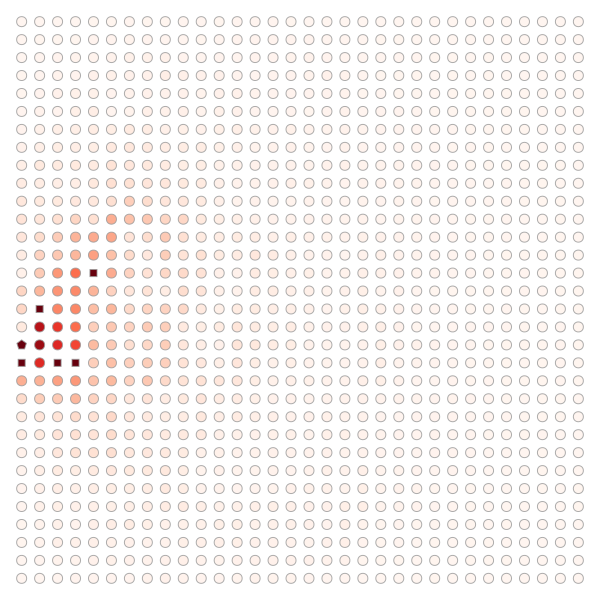

In [39]:
from viz_helpers import InfectionProbabilityViz
viz = InfectionProbabilityViz(g_und, pos)
viz.plot(c, obs, probas, output='figs/why-prederror-fails/inf-probas.png')


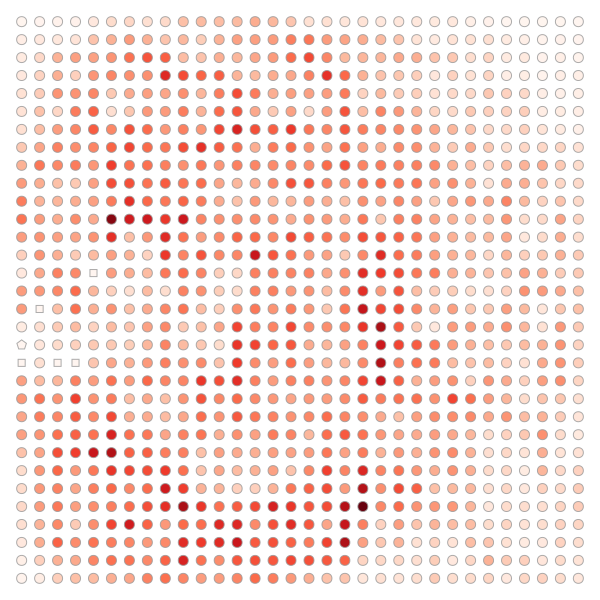

In [40]:
from viz_helpers import InfectionProbabilityViz
viz = InfectionProbabilityViz(g_und, pos)
viz.plot(c, obs, query_scores, output='figs/why-prederror-fails/query-score-transformed.png')


In [ ]:
from graph_helpers import extract_nodes_from_tuples

gv = remove_filters(g_rev)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=250,
    method='cut',
    gi=gi,
    return_type='tuples',
    with_inc_sampling=False)
sampler.fill(obs,
             root_sampler=build_true_root_sampler(c))
sample_sizes =[len(s)-1 for i, s in enumerate(sampler.samples)]

pd.Series(sample_sizes).hist()

In [ ]:
sample_id_sizes =[(i, len(s)) for i, s in enumerate(sampler.samples)]
sorted(sample_id_sizes, key=lambda tpl: abs(tpl[1] - len(inf_nodes)), reverse=True)

In [ ]:
t = sampler.samples[240]
# source = tuple(np.logical_and(t.degree_property_map('out').a > 0, t.degree_property_map('in').a == 0).nonzero()[0])
print(source)
tree_nodes = tuple(extract_nodes_from_tuples(t))
tree_edges = tuple(t)

node_color_info = OrderedDict()
node_color_info[tree_nodes] = 0.5
node_color_info[tuple(obs)] = 1.0
node_color_info[(source, )] = 1.0
node_color_info['default'] = 0

node_shape_info = OrderedDict()
node_shape_info[tuple(obs)] = 'square'
node_shape_info['default'] = 'circle'
node_shape_info[(source, )] = 'pentagon'

node_size_info = {
    tuple(obs): 10,
    tree_nodes: 12.5,
    (source, ): 15,
    'default': 5
}
edge_color_info = {
    tree_edges: 'red',
    'default': 'white'
}
edge_pen_width_info = {
    'default': 2.0
}
visualize(g_und, pos,
          node_color_info,
          node_shape_info,
          node_size_info,
          edge_color_info,
          edge_pen_width_info,
          output='figs/why-prederror-fails/bad-tree.png')

In [ ]:
gv = remove_filters(g)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=1,
    method='cut',
    gi=gi,
    return_tree_nodes=False,
    with_inc_sampling=False)
sampler.fill(obs,
             root_sampler=build_true_root_sampler(c))

t = sampler.samples[0]
list(t.vertex(source).out_edges())
print(t)

In [ ]:
from graph_tool.topology import random_spanning_tree
pred = random_spanning_tree(g, root=source)
spt = GraphView(g, efilt=pred)
list(spt.vertex(source).in_edges())

In [ ]:
# what are the pruned nodes
# what's the infection probability and score of the query node